### **Text Classification with Naive Bayes using Scikit-Learn**





In [1]:
from sklearn.datasets import fetch_20newsgroups



# This line imports the fetch_20newsgroups function from Scikit-Learn's datasets module.
# The fetch_20newsgroups function is used to load the "20 newsgroups" dataset, a collection
#  of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups.
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

* **For simplicity here, we will select just a few of these categories, and download the training and testing set**

In [2]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [3]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



### **Term frequency-inverse document frequency (TF-IDF) vectorizer**


* In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the term frequency-inverse document frequency (TF-IDF) vectorizer, which weights the word counts by a measure of how often they appear in the documents, and create a pipeline that attaches it to a multinomial naive Bayes classifier.


* Aside:  One of the simplest methods of encoding data is by word counts: you take each snippet of text, count the occurrences of each word within it, and put the results in a table. For a vectorization of this data based on word count, by using Scikit-Learn's CountVectorizer.

* There are some issues with the CountVectorizer approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms. One approach to fix this is known as term frequency-inverse document frequency (TF–IDF).

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline



# The make_pipeline function in Scikit-Learn is a utility function
# to create a pipeline of transformers and estimators. A pipeline
# bundles together a sequence of data processing steps and modeling
# into a single scikit-learn estimator. This makes it convenient to
# apply the same processing steps to both training and testing data,
# ensuring consistency in data transformations.

# TfidfVectorizer() is a transformer that converts the raw text data into
# a matrix of TF-IDF features. When fit_transform is called on the pipeline,
# this transformer learns the vocabulary from the training data and transforms
# it into the TF-IDF representation.

# MultinomialNB(): This is an estimator that implements the naive Bayes algorithm
# for multinomially distributed data. It is one of the two classic naive Bayes variants
# used in text classification. When fit is called on the pipeline, this estimator is
# trained on the TF-IDF representation of the data.

# The pipeline ensures that the data goes through the transformation by TfidfVectorizer
# before being passed to MultinomialNB for training or prediction.



model = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())

* With this pipeline, we can apply the model to the training data, and predict labels for the test data.

In [5]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

* Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data.

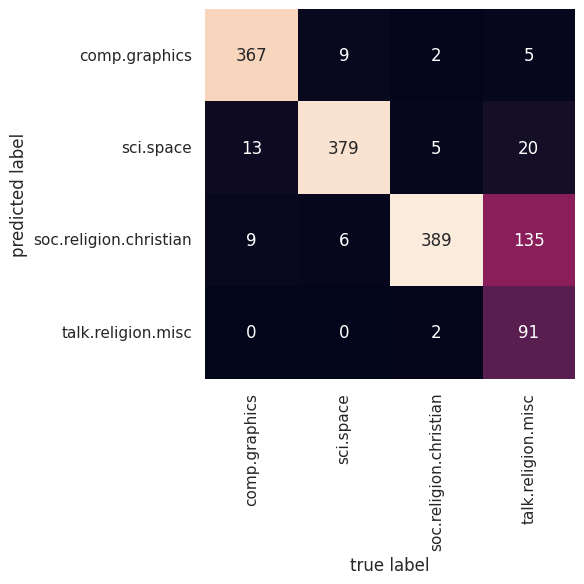

In [6]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

* This very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.

* We can now determine the category for any string, using the `predict()` method of this pipeline

In [7]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [8]:
predict_category('determining the screen resolution')

'comp.graphics'

* A TfidfVectorizer to transform the text data into TF-IDF feature vectors.
* A MultinomialNB classifier to perform the classification.

In [9]:
# Fit the model on the training data
model.fit(train.data, train.target)

# Extract the class labels and feature names
class_labels = train.target_names
feature_names = model.named_steps["tfidfvectorizer"].get_feature_names_out()

# Log probabilities refer to the logarithm of probabilities. In many computational
# applications, especially those involving small probabilities, it's often more
# convenient and numerically stable to work with log probabilities rather than raw
# probabilities.Get the log probabilities from the MultinomialNB model.
log_probabilities = model.named_steps["multinomialnb"].feature_log_prob_

# Extract the top features for each class
num_top_features = 10
top_features_per_class = {}

for i, class_label in enumerate(class_labels):
    top_features = log_probabilities[i].argsort()[-num_top_features:][::-1]
    top_feature_names = [feature_names[idx] for idx in top_features]
    top_features_per_class[class_label] = top_feature_names

# These are the words that the model determines to be most indicative of a
# particular class. They might not necessarily be the most frequent words.
#  Instead, they are words that, when present, provide strong evidence about the class of the document.
print(top_features_per_class)

from sklearn.metrics import accuracy_score

# Predict the class labels for the test data
predicted_labels = model.predict(test.data)

# Compute the accuracy
accuracy = accuracy_score(test.target, predicted_labels)

print(f"Model Accuracy: {accuracy:.2f}")


{'comp.graphics': ['graphics', 'edu', 'com', 'lines', 'image', 'university', 'files', 'subject', 'organization', 'posting'], 'sci.space': ['space', 'edu', 'nasa', 'henry', 'access', 'com', 'alaska', 'gov', 'moon', 'toronto'], 'soc.religion.christian': ['god', 'edu', 'jesus', 'people', 'church', 'christians', 'bible', 'believe', 'christian', 'hell'], 'talk.religion.misc': ['com', 'sandvik', 'edu', 'god', 'jesus', 'people', 'kent', 'christian', 'morality', 'writes']}
Model Accuracy: 0.86


## **Exercise:**

* Write a Python function named `naive_bayes_text_classifier` that takes in training and test data and returns the accuracy of a Naive Bayes classifier and the top 10 indicative words for each category.

* Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from Scikit-Learn to preprocess the messages. Train a Naive Bayes classifier using MultinomialNB on the training data.



In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


def naive_bayes_text_classifier(train_data, test_data):
    """
    Train a Naive Bayes classifier on text data and return its accuracy and the top indicative words for each category.

    This function preprocesses the text data using CountVectorizer from Scikit-Learn, trains a Naive Bayes classifier
    using MultinomialNB on the training data, and then evaluates its accuracy on the test data. It also extracts the top
    10 indicative words for each category based on the trained Naive Bayes model.

    Parameters:
    -----------
    train_data : sklearn.utils.Bunch
        Training data obtained from fetch_20newsgroups with subset='train'.
        Expected attributes are 'data' for the text data and 'target' for the labels.

    test_data : sklearn.utils.Bunch
        Test data obtained from fetch_20newsgroups with subset='test'.
        Expected attributes are 'data' for the text data and 'target' for the labels.

    Returns:
    --------
    accuracy : float
        Accuracy of the Naive Bayes classifier on the test data.

    top_words_per_category : dict
        A dictionary where keys are category names and values are lists of the top 10 indicative words for each category.

    Example:
    --------
    >>> from sklearn.datasets import fetch_20newsgroups
    >>> selected_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
    >>> train_data = fetch_20newsgroups(subset='train', categories=selected_categories)
    >>> test_data = fetch_20newsgroups(subset='test', categories=selected_categories)
    >>> accuracy, top_words_per_category = naive_bayes_text_classifier(train_data, test_data)
    >>> print(f"Accuracy: {accuracy:.2f}")
    Accuracy: 0.95
    >>> for category, words in top_words_per_category.items():
    ...     print(f"Top words for {category}: {words}")
    Top words for talk.religion.misc: [...]
    Top words for soc.religion.christian: [...]
    Top words for sci.space: [...]
    Top words for comp.graphics: [...]
    """
    # Preprocess the messages using CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    X_train = vectorizer.fit_transform(train_data.data)
    y_train = train_data.target

    X_test = vectorizer.transform(test_data.data)
    y_test = test_data.target

    # Train a Naive Bayes classifier on the training data
    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    feature_names = vectorizer.get_feature_names_out()
    top_n = 10

    top_words_per_category = {}
    for i, category in enumerate(train_data.target_names):
        sorted_feature_indexes = clf.feature_log_prob_[i].argsort()
        top_words = [feature_names[idx] for idx in sorted_feature_indexes[-top_n:]]
        top_words_per_category[category] = top_words

    return accuracy, top_words_per_category


selected_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train_data = fetch_20newsgroups(subset='train', categories=selected_categories)
test_data = fetch_20newsgroups(subset='test', categories=selected_categories)

accuracy, top_words_per_category = naive_bayes_text_classifier(train_data, test_data)
print(f"Accuracy: {accuracy:.2f}")
for category, words in top_words_per_category.items():
    print(f"Top words for {category}: {words}")



Accuracy: 0.93
Top words for comp.graphics: ['file', 'posting', 'university', 'com', 'image', 'organization', 'graphics', 'subject', 'lines', 'edu']
Top words for sci.space: ['gov', 'article', 'writes', 'com', 'lines', 'organization', 'subject', 'nasa', 'edu', 'space']
Top words for soc.religion.christian: ['church', 'know', 'think', 'organization', 'lines', 'jesus', 'people', 'subject', 'edu', 'god']
Top words for talk.religion.misc: ['article', 'writes', 'lines', 'jesus', 'organization', 'people', 'subject', 'god', 'com', 'edu']
